In [2]:
#Load required modules
import os
import argparse
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from monai import transforms
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import json
from networks.SiameseNetwork import SiameseNetwork

from pytorch_metric_learning.losses import NTXentLoss
from dataset.nih_chest_xray_cl import NIHXRayDataset
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

In [3]:
gpu_no = 0      
device = torch.device("cuda:"+str(gpu_no) if torch.cuda.is_available() else "cpu")    
model = SiameseNetwork()
Siamese = model 
model.to(device)
model.eval()

#self supervised model
exp = 'exp_2D/'
model_dir = 'ckpt/'
model.load_state_dict(torch.load(model_dir+exp+'model'))



The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


<All keys matched successfully>

In [4]:
#Load Training validation and snythetic data
training_samples = 10000
downsample = 2
batch_size = 50
data_dir = 'data/NIHXRay'
train_data = NIHXRayDataset(root_dir= data_dir, split = 'train', training_samples = training_samples, donwsample = downsample)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

validation_samples = 10000
val_data = NIHXRayDataset(root_dir= data_dir, split = 'val', validation_samples = validation_samples, donwsample = downsample)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)


In [6]:

data_synth_dir = 'data/monai-2D/'
synth_data = np.float16(np.load(data_synth_dir +  'synthesized_samples_2999.npz')['synth'])
#normalize synthetic data
for ii in range(synth_data.shape[0]):
    synth_data[ii,:] = (synth_data[ii,:]-synth_data[ii,:].min())/(synth_data[ii,:].max()-synth_data[ii,:].min()+1e-4)


In [7]:

load_embeddings = True
if load_embeddings:
    #load saved embeddings

    results_file_emb = data_synth_dir + 'embeddings.npz'
    loaded_emb = np.load(results_file_emb)
    synth_embeddings_saved =  loaded_emb['synth_embeddings']
    synth_embeddings = synth_embeddings_saved[-1,:]
    train_embeddings =  loaded_emb['train_embeddings']
    val_embeddings=  loaded_emb['val_embeddings']    
print (not(load_embeddings))    

if not(load_embeddings):
    #Load training and validation embeddings
    train_embeddings = []; val_embeddings = []
    with torch.no_grad():
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
        progress_bar.set_description("Training Data")   
        for step, batch in progress_bar:
            sample = batch['data'].to(device)
            #emb, _ = model(sample); train_embeddings.append(emb.cpu().numpy())
            emb = Siamese(sample, resnet_only = True); train_embeddings.append(emb.cpu().numpy())
        progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=110)
        progress_bar.set_description("Validation Data")   
        for step, batch in progress_bar:
            sample = batch['data'].to(device)
            #emb, _ = model(sample);  val_embeddings.append(emb.cpu().numpy())
            emb = Siamese(sample, resnet_only = True); val_embeddings.append(emb.cpu().numpy())
        train_embeddings = np.array(train_embeddings)
        val_embeddings = np.array(val_embeddings)
        
    samples = np.prod(train_embeddings.shape[0:-1]); emb_dim = train_embeddings.shape[-1]
    train_embeddings = np.reshape(train_embeddings, (np.prod(train_embeddings.shape[0:-1]),-1))
    val_embeddings = np.reshape(val_embeddings, (np.prod(val_embeddings.shape[0:-1]),-1))

Validation Data: 100%|██████████████████████████████████████████████████████| 200/200 [07:19<00:00,  2.20s/it]


In [8]:

if not(load_embeddings):
    synth_data = np.float32(synth_data)
    synth_embeddings = []
    with torch.no_grad():
        #with autocast():
            Idx = np.arange(0,validation_samples)
            #dividde into batches
            Batches = np.array_split(Idx, np.floor(len(Idx)/batch_size))

            progress_bar = tqdm(enumerate(Batches), total=len(Batches), ncols=100)
            progress_bar.set_description("Synthetic Data")   

            for BatchNo, Batch in progress_bar:
                sample = torch.from_numpy(synth_data[Batch,:]).to(device)
                #emb, _ = model(sample); synth_embeddings.append(emb.cpu().numpy())
                emb = Siamese(sample, resnet_only = True); synth_embeddings.append(emb.cpu().numpy())
    synth_embeddings = np.array(synth_embeddings)
    synth_embeddings = np.reshape(synth_embeddings, (np.prod(synth_embeddings.shape[0:-1]),-1))



Synthetic Data: 100%|█████████████████████████████████████████████| 200/200 [01:19<00:00,  2.51it/s]


In [9]:
#Calculate differences/similarities

loss_type = 'correlation'

Nsamples = 10000
train_train_diff =cdist (train_embeddings[0:Nsamples, :], train_embeddings[0:Nsamples, :],loss_type)
train_val_diff=cdist (train_embeddings[0:Nsamples, :], val_embeddings,loss_type)
train_synth_diff =cdist (train_embeddings[0:Nsamples, :], synth_embeddings,loss_type)
val_synth_diff =cdist ( val_embeddings,synth_embeddings,  loss_type)
synth_train_diff = train_synth_diff.transpose()

train_synth_diff_sorted_idx = np.argsort(train_synth_diff, axis = -1)
train_synth_diff_sorted = np.sort(train_synth_diff, axis = -1)
train_synth_diff_sorted_idx2 = np.argsort(train_synth_diff_sorted[:,0], axis = -1)

val_synth_diff_sorted_idx = np.argsort(val_synth_diff, axis = -1)
val_synth_diff_sorted = np.sort(val_synth_diff, axis = -1)
val_synth_diff_sorted_idx2 = np.argsort(val_synth_diff_sorted[:,0], axis = -1)

synth_train_diff_sorted_idx = np.argsort(synth_train_diff , axis = -1)
synth_train_diff_sorted = np.sort(synth_train_diff , axis = -1)
synth_train_diff_sorted_idx2 = (np.argsort(synth_train_diff_sorted[:,0], axis = -1))   


train_train_diff_sorted_idx = np.argsort(train_train_diff, axis = -1)
train_train_diff_sorted = np.sort(train_train_diff, axis = -1)
train_train_diff_sorted_idx2 = np.argsort(train_train_diff_sorted[:,1], axis = -1)


train_val_diff_sorted_idx = np.argsort(train_val_diff, axis = -1)
train_val_diff_sorted = np.sort(train_val_diff, axis = -1)
train_val_diff_sorted_idx2 = np.argsort(train_val_diff_sorted[:,0], axis = -1)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


(10000,)
Training samples that are copies: 3264
Synthesized samples that are copies: 5453


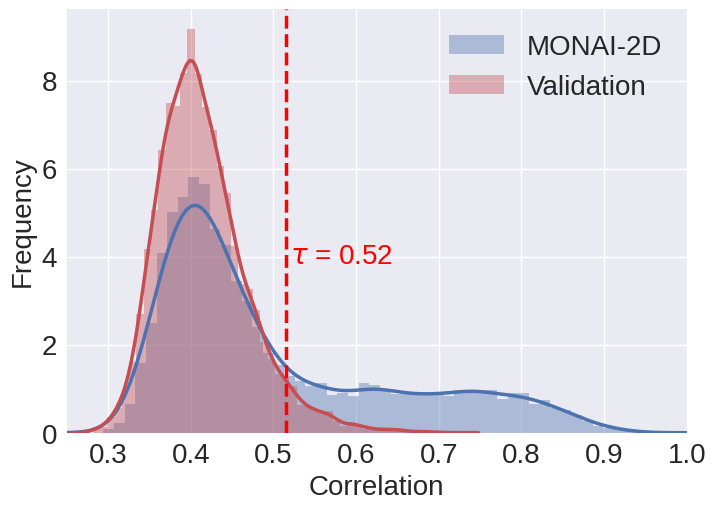

In [15]:
import seaborn as sns
from scipy import stats
bins = 50
fontsize = 20

plt.figure()

linewidth = 2.5
aa = sns.distplot( 1 - train_synth_diff_sorted[0:Nsamples, 0] ,hist= True,  kde_kws={'clip': (0.0, 1.0), 'linewidth' :linewidth}, label="MONAI-2D",  kde = True, bins = bins, fit_kws={'color':"blue"} )
bb = sns.distplot( 1 - train_val_diff_sorted[0:Nsamples, 0], color='#c44e52',hist= True, kde_kws={'clip': (0.0, 1.0), 'linewidth' :linewidth},label="Validation", kde = True, bins = bins, fit_kws={'color':"red"})


prctl =np.percentile(1-train_val_diff_sorted[0:Nsamples, 0], 95)
plt.axvline(prctl, color='red', linestyle='dashed',linewidth=linewidth)

min_ylim, max_ylim = plt.ylim()


plt.xlabel('Correlation', fontsize=fontsize);plt.ylabel('Frequency', fontsize=fontsize)
plt.legend( fontsize=fontsize); #plt.ylim((0,34)); #
plt.xlim((0.25,1))
plt.xticks(fontsize=fontsize);plt.yticks(fontsize=fontsize)
plt.text(prctl*1.01, max_ylim*0.4, r'$\tau$ = {:.2f}'.format(prctl), fontsize=fontsize, color = "red")

print(train_val_diff_sorted[0:Nsamples, 0].shape)
print('Training samples that are copies: '+ str(np.sum((1-train_synth_diff_sorted[0:Nsamples,0] )>prctl)))
print('Synthesized samples that are copies: '+ str(np.sum((1-synth_train_diff_sorted[0:Nsamples, 0] )>prctl)))
copies_idx = (1-train_synth_diff_sorted[0:Nsamples, 0] )>prctl



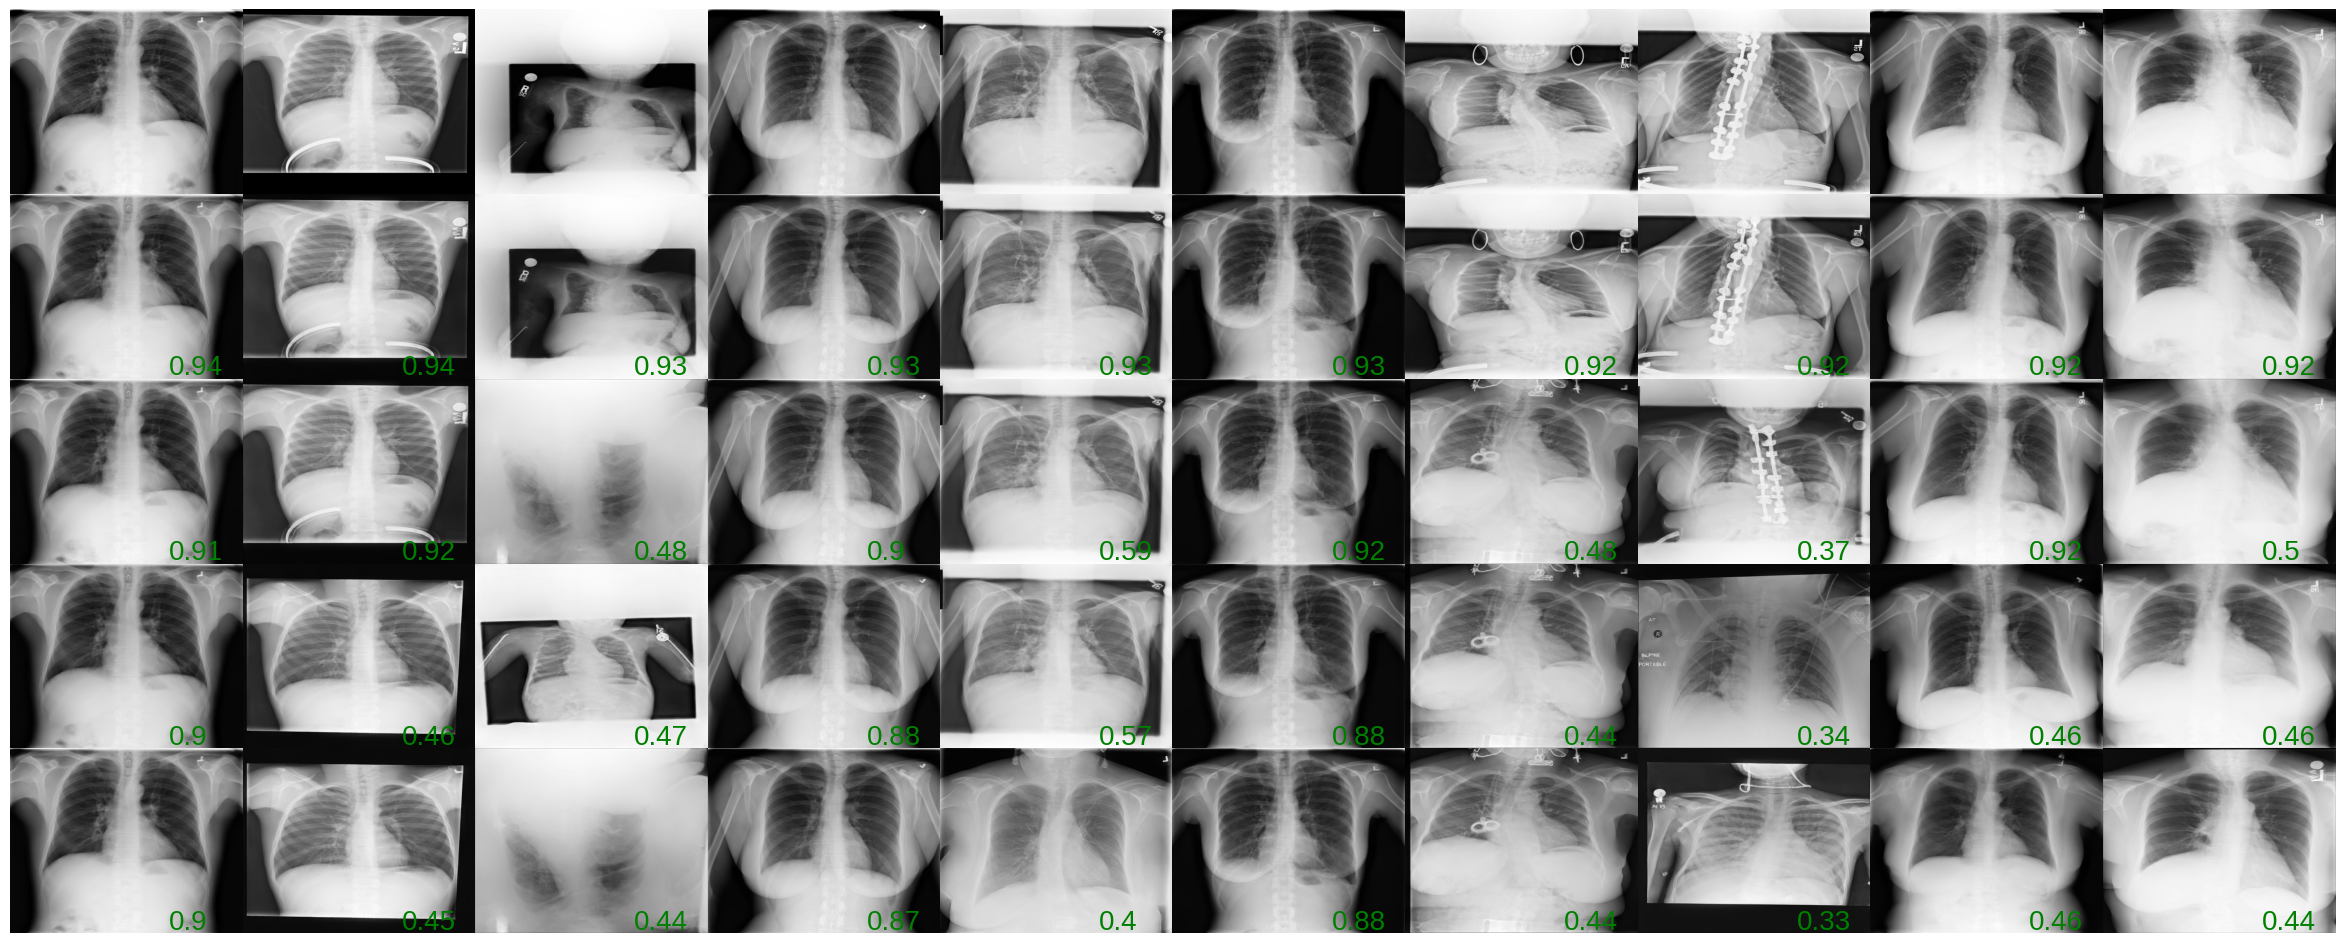

In [13]:
#Plot examples closest synthetic samples
sample_nos =  list(range(0,10))
scale = 3; nn_images = 4
fig, ax = plt.subplots(nrows= nn_images+1, ncols=len(sample_nos), gridspec_kw = {'wspace':0, 'hspace':0}, figsize = (len(sample_nos)*scale,4*scale))

#fig.tight_layout()

for index, sample_no in enumerate(sample_nos):
    idx_train_synth =   train_synth_diff_sorted_idx2[sample_no]
    idx_synth =[None]*nn_images
    for ii in range(len(idx_synth)):
        idx_synth[ii]=   train_synth_diff_sorted_idx[idx_train_synth, ii]
        ax[ii+1, index].imshow(synth_data[idx_synth[ii],0,:], cmap="gray")
        ax[ii+1, index].axis('off');ax[ii+1,index ].axis('tight') 

        ax[ii+1, index].text(350,500,str(round(1-train_synth_diff[ idx_train_synth,idx_synth[ii]],2)), fontsize=20,color = 'g')
    ax[0,index ].imshow(train_data.__getitem__(idx_train_synth)["data"][0, :, :].numpy(), cmap="gray")
    ax[0,index ].axis('off');ax[0,index ].axis('tight') 
    


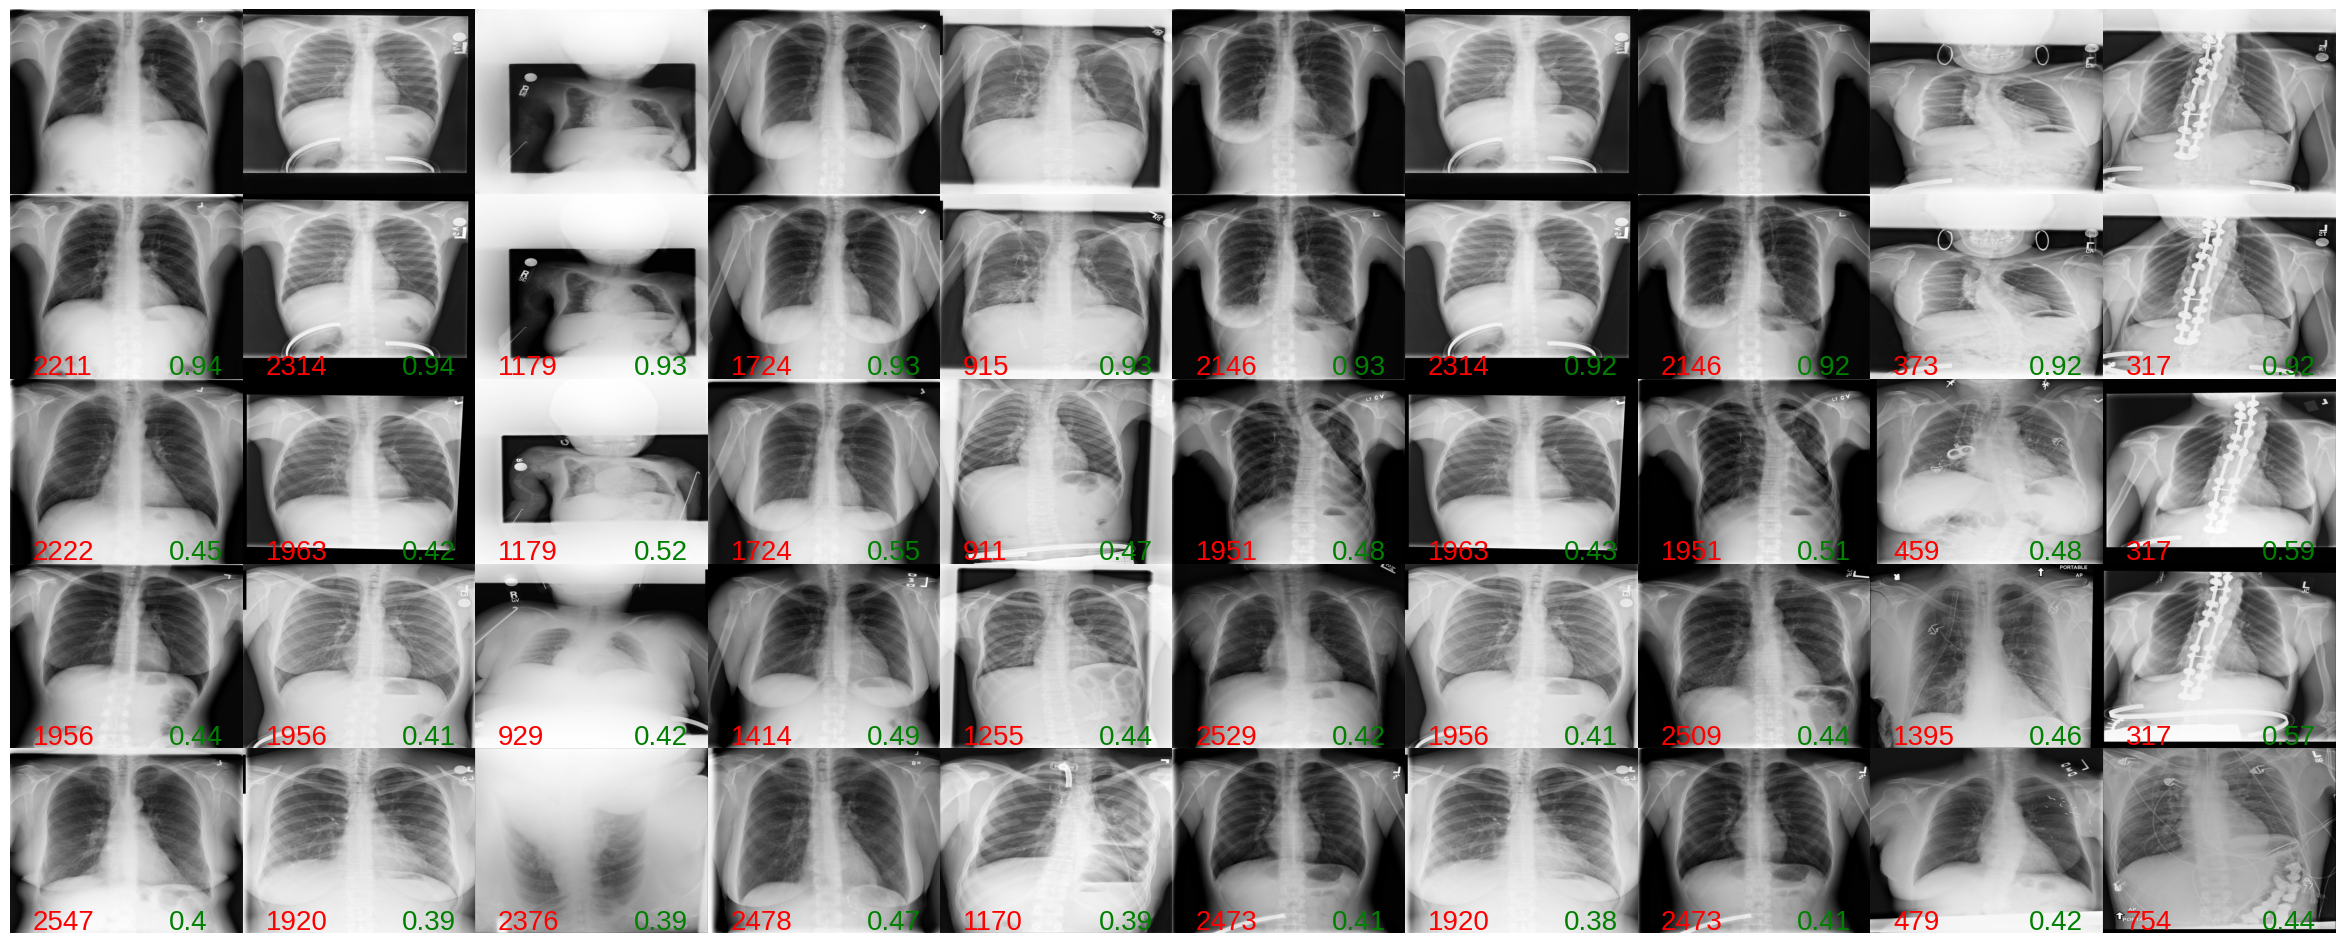

In [14]:

#Plot examples closest synthetic samples
sample_nos =  list(range(0,10))
scale = 3; nn_images = 4
fig, ax = plt.subplots(nrows= nn_images+1, ncols=len(sample_nos), gridspec_kw = {'wspace':0, 'hspace':0}, figsize = (len(sample_nos)*scale,4*scale))

#fig.tight_layout()

for index, sample_no in enumerate(sample_nos):
    idx_synth_train =   synth_train_diff_sorted_idx2[sample_no]
    idx_train =[None]*nn_images; pat_no = [None]*nn_images
    for ii in range(len(idx_train)):
        idx_train[ii]=   synth_train_diff_sorted_idx[idx_synth_train, ii]
        ax[ii+1, index].imshow(train_data.__getitem__(idx_train[ii])["data"][0, :, :].numpy(), cmap="gray")
        ax[ii+1, index].axis('off');ax[ii+1,index ].axis('tight') 
        pat_no[ii] = int(train_data.__getitem__(idx_train[ii])["path"].split("/")[-1].split('_')[0].split('.')[0])
        ax[ii+1, index].text(50,500,str(pat_no[ii]), fontsize=20,color = 'r')
        ax[ii+1, index].text(350,500,str(round(1-synth_train_diff[ idx_synth_train,idx_train[ii]],2)), fontsize=20,color = 'g')
    #print('Training patients: '+str(pat_no))
    #print('\n')
    ax[0,index ].imshow(synth_data[idx_synth_train,0,:], cmap="gray")
    ax[0,index ].axis('off');ax[0,index ].axis('tight') 


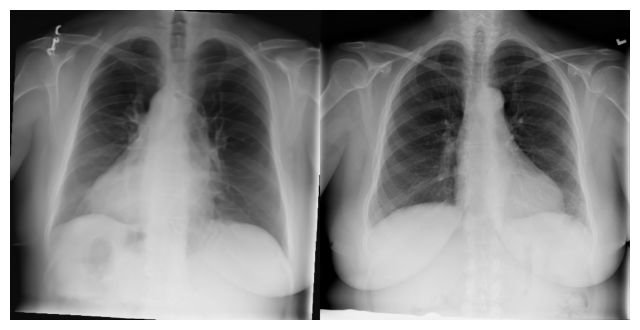

In [51]:
#save random 100 pairs (not necessarily copies, this was to to manual evaluation)
np.random.seed(100)
sample_nos = np.random.randint(0,Nsamples,100)
for index, sample_no in enumerate(sample_nos):
    idx_train_synth =   train_synth_diff_sorted_idx2[sample_no]
    idx_synth=   train_synth_diff_sorted_idx[idx_train_synth, 0]
    img = np.concatenate((synth_data[idx_synth,0,:],train_data.__getitem__(idx_train_synth)["data"][0, :, :].numpy()),axis=1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig('results/exp_2D/'+str(sample_no)+'.png')